## Descarga de datos de candidatos en yoparticipo

Librerías

In [51]:
import asyncio
from playwright.async_api import async_playwright
import pandas as pd
from IPython.display import display, Image, clear_output
import base64
import json
from pathlib import Path
from google import genai
from google.genai import types

Cargar la lista de candidatos

In [67]:
df = pd.read_parquet("datos/2025.parquet")

Transcripción

In [55]:
def gemini_transcribe(base64_data, model="gemini-2.0-flash-lite"):
    image_part = types.Part.from_bytes(
        data=base64.b64decode(base64_data), mime_type="image/jpeg"
    )

    response = client.models.generate_content(
        model=model,
        contents=[
            "Transcribe this 6-character hexadecimal string shown in the image. Return only the 6-character hex string.",
            image_part,
        ],
    )
    return response.text

Extraer datos de una persona

In [56]:
async def process_row(page, row):
    for attempt in range(3):
        try:
            # Load form
            await page.goto("https://yoparticipo.oep.org.bo/auth/signin", timeout=5000)
            await page.wait_for_load_state()
            print("Page loaded")

            # Fill form
            await page.fill("#documentId-input", str(row["nro_documento"].replace(" ", "-")))
            await page.fill(
                "#birthDate-input", row["fecha_nacimiento"].strftime("%Y-%m-%d")
            )

            # Get captcha
            captcha_element = await page.query_selector("#captcha-image")
            captcha_src = await captcha_element.get_attribute("src")
            base64_data = captcha_src.split(",")[1]
            display(Image(data=base64.b64decode(base64_data)))

            # Transcribe
            captcha_value = gemini_transcribe(base64_data)
            # captcha_value = input("Enter CAPTCHA: ")
            print(captcha_value)
            
            # Fill captcha
            await page.fill("#captcha-input", captcha_value)

            # Submit form
            await page.click("#sign-in-submit-button")

            # Load data
            await page.wait_for_url("https://yoparticipo.oep.org.bo/", timeout=5000)

            # Extract data
            # Location
            location = await page.query_selector_all("#location h3.text-blue-950")
            values = {}
            for name, element in zip(
                ["pais", "departamento", "localidad", "recinto", "mesa"], location
            ):
                values[name] = await element.inner_text()

            # Militancia
            militancia = await page.query_selector_all("#militant h3.text-blue-950")
            militancia_values = [await el.inner_text() for el in militancia] + [
                None
            ] * 3
            militancia_values = militancia_values[:3]
            for name, element in zip(
                ["militancia", "partido", "partido_short"], militancia_values
            ):
                values[name] = element

            return values

        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            await asyncio.sleep(3)

    print("Max retries exceeded.")
    return None

Extraer datos de todos los candidatos

In [57]:
async def run(dataframe):
    async with async_playwright() as p:

        # New browser
        browser = await p.chromium.launch(headless=True)

        # For all pending rows
        for i in range(start_index, len(dataframe)):

            # Prepare
            row = dataframe.iloc[i]
            clear_output(wait=True)
            print(f"\n[{i + 1} / {len(dataframe)}] Documento: {row['nro_documento']}")
            await asyncio.sleep(2)

            # Open a tab and get data
            page = await browser.new_page()
            result = await process_row(page, row)
            await page.close()

            # If there's data, store it and update the checkpoint
            if result:
                record = {**{"nro_documento": row["nro_documento"]}, **result}
                data.append(record)

                with open(checkpoint_file, "w") as f:
                    json.dump(
                        {"last_index": i, "data": data}, f, ensure_ascii=False, indent=2
                    )
            else:
                print(f"Stopping at row {i} due to repeated failure.")
                break

        await browser.close()

Correr


[1864 / 1864] Documento: 3836306
Page loaded


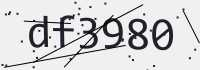

df3980



In [63]:
# Setup the loop
data = []
checkpoint_file = Path("checkpoint.json")
start_index = 0
client = genai.Client(api_key="mykey")

# Checkpoint
if checkpoint_file.exists():
    with open(checkpoint_file) as f:
        checkpoint = json.load(f)
        start_index = checkpoint["last_index"] + 1
        data = checkpoint["data"]
        print(f"Resuming from row {start_index}")
        
await run(df)

Consolidar resultados en una tabla

In [64]:
yp = pd.DataFrame(data)
consolidado = pd.merge(yp, df, how="inner", on="nro_documento", suffixes=("_yoparticipo", "_listas"))
consolidado.sample()

,nro_documento,pais,departamento_yoparticipo,localidad,recinto,mesa,militancia,partido_yoparticipo,partido_short,partido_listas,...,departamento_listas,orden,posición,titularidad,nombre_completo,genero,edad,fecha_nacimiento,descripcion,observacion
938,9932046,BOLIVIA,La Paz,"Murillo, El Alto",U. E. Cosmos 79,05,USTED NO ES MILITANTE,None,None,LA FUERZA DEL PUEBLO (FP),...,La Paz,15,10,TITULAR,ROSA ANGELA VARGAS LAYME,F,28,1996-12-20,,


Registros con errores

In [71]:
errores = yp[yp.departamento.isna()]
errores

,nro_documento,pais,departamento,localidad,recinto,mesa,militancia,partido,partido_short
97,4417191,NaN,NaN,NaN,NaN,NaN,None,None,None


Reintentar registros con errores


[1 / 1] Documento: 4417191
Page loaded


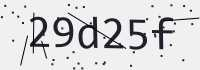

29d25f



In [72]:
start_index = 0

# Checkpoint

with open(checkpoint_file) as f:
    checkpoint = json.load(f)
    data = checkpoint["data"]

await run(df[df.nro_documento.isin(errores.nro_documento)])

Consolidar de nuevo

In [76]:
yp = pd.DataFrame(data)
yp.drop_duplicates(["nro_documento"], keep="last", inplace=True)
consolidado = pd.merge(
    yp, df, how="inner", on="nro_documento", suffixes=("_yoparticipo", "_listas")
)
consolidado.sample()

,nro_documento,pais,departamento_yoparticipo,localidad,recinto,mesa,militancia,partido_yoparticipo,partido_short,partido_listas,...,departamento_listas,orden,posición,titularidad,nombre_completo,genero,edad,fecha_nacimiento,descripcion,observacion
673,5483455,BOLIVIA,La Paz,"Murillo, El Alto",U. E. Franz Tamayo de Río Seco A,04,USTED NO ES MILITANTE,None,None,LIBERTAD Y DEMOCRACIA (LIBRE),...,La Paz,6,6,TITULAR,ALICIA AVALOS CONDORI,F,50,1975-05-17,,


Guardar

In [88]:
yp.to_parquet("datos/yoparticipo.parquet")

## Algunas vistas

Comparación entre partidos en lista y en yoparticipo

In [80]:
consolidado.groupby("partido_listas", as_index=False).partido_yoparticipo.value_counts(
    dropna=False
).fillna("Ninguno").pivot_table(
    columns="partido_listas", index="partido_yoparticipo", values="count"
).fillna(0).astype(int)

partido_listas,ALIANZA POPULAR (AP),AUTONOMÍA PARA BOLIVIA SÚMATE (APB-SUMATE),CONSEJO INDÍGENA YUQUI BIA RECUATE (BIA-YUQUI),LA FUERZA DEL PUEBLO (FP),LIBERTAD Y DEMOCRACIA (LIBRE),LIBERTAD Y PROGRESO ADN (LYP-ADN),MOVIMIENTO AL SOCIALISMO INSTRUMENTO POLITICO POR LA SOBERANIA DE LOS PUEBLOS (MAS-IPSP),MOVIMIENTO DE RENOVACIÓN NACIONAL (MORENA),ORGANIZACIÓN INDÍGENA CHIQUITANA (OICH),PARTIDO DEMOCRATA CRISTIANO (PDC),UNIDAD (UNIDAD)
partido_yoparticipo,,,,,,,,,,,
ACCION DEMOCRATICA NACIONAL,0,0,0,0,1,3,0,0,0,1,0
ACCION DEMOCRATICA NACIONALISTA,0,0,0,0,0,1,0,0,0,0,0
ALIANZA DE INTEGRACION REGIONAL,0,0,0,0,0,0,0,0,0,0,1
ALIANZA SOCIAL PATRIOTICA,0,0,0,0,0,0,0,0,0,0,1
ALIANZA SOLIDARIA POPULAR (ASIP),0,1,0,0,0,0,0,0,0,1,0
AUTONOMIA PARA BOLIVIA SUMATE,1,62,0,1,1,1,0,0,0,1,1
CAMINO DEMOCRATICO PARA EL CAMBIO,0,0,0,0,0,0,0,0,0,1,0
COLUMNA DE INTEGRACION,0,1,0,0,4,0,0,0,0,0,0
CREEMOS,0,1,0,0,0,2,0,0,0,0,25


Casos donde un candidato está registrado en un departamento distinto de su registro en el padrón 

In [86]:
consolidado[
    (consolidado.departamento_listas != "Nacional")
    & (consolidado.departamento_yoparticipo != consolidado.departamento_listas)
][
    [
        "nro_documento",
        "nombre_completo",
        "partido_listas",
        "candidatura",
        "descripcion",
        "departamento_yoparticipo",
        "departamento_listas",
    ]
]

,nro_documento,nombre_completo,partido_listas,candidatura,descripcion,departamento_yoparticipo,departamento_listas
816,1868098,ADRIANA ESTEFANIA AGUIRRE CASTELLANOS,LIBERTAD Y DEMOCRACIA (LIBRE),Diputados de Circunscripciones Plurinominales,,La Paz,Tarija
919,5479519,LUISA JULIA MAMANI CHOQUE,LA FUERZA DEL PUEBLO (FP),Senadores,,La Paz,Chuquisaca
920,8428089,VANIA JOELMA GUZMAN CAMACHO,LA FUERZA DEL PUEBLO (FP),Senadores,,La Paz,Chuquisaca
921,4377420,MARIA ROSA MORALES PACO,LA FUERZA DEL PUEBLO (FP),Senadores,,La Paz,Chuquisaca
922,9216008,RUBEN DEYBID TARQUI FERNANDEZ,LA FUERZA DEL PUEBLO (FP),Senadores,,La Paz,Chuquisaca
953,8037145,ERIKA CALIZAYA ZENTENO,LA FUERZA DEL PUEBLO (FP),Diputados de Circunscripciones Plurinominales,,Cochabamba,La Paz
954,6558922,SAMUEL AMARU SIMON,LA FUERZA DEL PUEBLO (FP),Diputados de Circunscripciones Plurinominales,,Cochabamba,La Paz
955,6444215,BRENDA ARELLANO BLANCO,LA FUERZA DEL PUEBLO (FP),Diputados de Circunscripciones Plurinominales,,Cochabamba,La Paz
956,5900432,JUAN SERGIO HUANCA MONTOYA,LA FUERZA DEL PUEBLO (FP),Diputados de Circunscripciones Plurinominales,,Cochabamba,La Paz
958,652479,JUAN CABRERA FERNANDEZ,LA FUERZA DEL PUEBLO (FP),Diputados de Circunscripciones Plurinominales,,Oruro,Cochabamba


In [83]:
df.sample()

,partido,candidatura,departamento,orden,posición,titularidad,nombre_completo,nro_documento,genero,edad,fecha_nacimiento,descripcion,observacion
112,UNIDAD (UNIDAD),Diputados de Circunscripciones Uninominales,Cochabamba,10,1,SUPLENTE,MARIA VOLGA VERDUGUEZ ZABALA,4513437,F,47,1978-04-20,Circunscripción 26,


In [90]:
consolidado.sample().T

,90
nro_documento,4452508
pais,BOLIVIA
departamento_yoparticipo,Cochabamba
localidad,"Quillacollo, Colcapirhua"
recinto,Escuela Jesus Lara
mesa,20
militancia,USTED NO ES MILITANTE
partido_yoparticipo,None
partido_short,None
partido_listas,ALIANZA POPULAR (AP)
